In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as pp
import os
from PIL import Image
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report)
from sklearn.utils.class_weight import compute_class_weight

In [2]:
data = pd.read_csv('~/AAI-510/Final Project/Data/diamond_data.csv')[['path_to_img','clarity','shape']]
data['path_to_img'] = '~/AAI-510/Final Project/Data' + data['path_to_img'].str[11:]
data.dropna(inplace=True)
data['path_to_img'] = data['path_to_img'].apply(os.path.expanduser) #Since tensor cannot read ~ locations, we need to give absolute path, I have done it here so that this code can run on any machine
data

,path_to_img,clarity,shape
0,C:\Users\Shreyas/AAI-510/Final Project/Data/cu...,SI2,cushion
1,C:\Users\Shreyas/AAI-510/Final Project/Data/cu...,SI2,cushion
2,C:\Users\Shreyas/AAI-510/Final Project/Data/cu...,SI1,cushion
3,C:\Users\Shreyas/AAI-510/Final Project/Data/cu...,VS2,cushion
4,C:\Users\Shreyas/AAI-510/Final Project/Data/cu...,SI1,cushion
...,...,...,...
48760,C:\Users\Shreyas/AAI-510/Final Project/Data/ro...,VVS1,round
48761,C:\Users\Shreyas/AAI-510/Final Project/Data/ro...,IF,round
48762,C:\Users\Shreyas/AAI-510/Final Project/Data/ro...,VVS2,round
48763,C:\Users\Shreyas/AAI-510/Final Project/Data/ro...,FL,round


In [3]:
suspicious_paths = data['path_to_img'].iloc[:]  # A few before & after
for path in suspicious_paths:
    try:
        with Image.open(path) as img:
            img.verify()
    except Exception as e:
        print(f"❌ CORRUPT: {path} — {e}")

❌ CORRUPT: C:\Users\Shreyas/AAI-510/Final Project/Data/emerald/220188-630.jpg — cannot identify image file 'C:\\Users\\Shreyas/AAI-510/Final Project/Data/emerald/220188-630.jpg'


In [4]:
# Step 1: Expand user paths (~) and absolute paths
data['path_to_img'] = data['path_to_img'].apply(os.path.expanduser)
data['path_to_img'] = data['path_to_img'].apply(os.path.abspath)

data = data[data['path_to_img'] != "C:\\Users\\Shreyas\\AAI-510\\Final Project\\Data\\emerald\\220188-630.jpg"] #The picture which is apparently corrupted

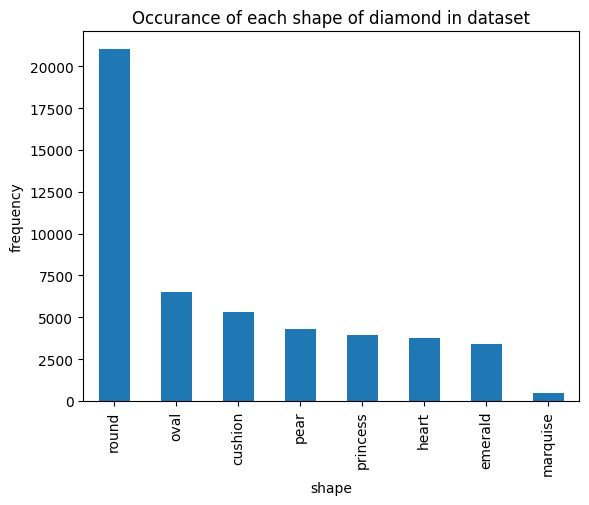

In [5]:
freq = data['shape'].value_counts()
freq.plot(kind='bar')
pp.xlabel('shape')
pp.ylabel('frequency')
pp.title('Occurance of each shape of diamond in dataset')
pp.show()

In [6]:
freq

shape
round       21031
oval         6488
cushion      5318
pear         4329
princess     3949
heart        3755
emerald      3391
marquise      465
Name: count, dtype: int64

In [7]:
def image_return(loc,target):
    img = cv2.imread(os.path.expanduser(loc),cv2.IMREAD_GRAYSCALE)

    img_size = 255
    img = cv2.resize(img,(img_size,img_size),1)
    img = img/255.0
    
    return img,target

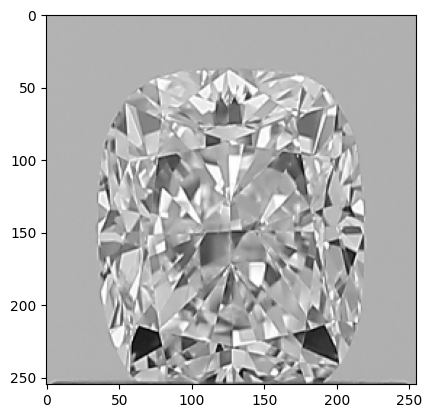

In [8]:
pp.imshow(image_return(data['path_to_img'][45],data['clarity'][45])[0],cmap='grey')

In [9]:
#As one can see, there are many categories which have negligible samples. The model obviously will not perform well on these by themselves.
#Instead, there are some groupings we can do. grouping the VVS, VS, SL, L together and have IL and IF separate. This makes sense intuitively
#And allows for usage in the real world since a person cannot distinguish between VVS1 and VVS2 anyway.

IF_ELSE_COND = [
    data['clarity'].str.contains('VVS', na=False),
    data['clarity'].str.contains('VS', na=False),
    data['clarity'].str.contains('SI', na=False),
    data['clarity'].str.contains('I', na=False),
    data['clarity'] == 'IF',
    data['clarity'] == 'FL'
]

final_clarity = ['VVS', 'VS', 'SL', 'L', 'IF', 'FL']

data['clarity_new'] = np.select(IF_ELSE_COND,final_clarity,default=np.NaN)
print(data['clarity_new'].unique())

data.drop('clarity',axis=1,inplace=True)
data.rename(columns={'clarity_new' : 'clarity'},inplace=True)

['SL' 'VS' 'VVS' 'L' 'FL']


C:\Users\Shreyas\AppData\Local\Temp\ipykernel_55524\248096296.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clarity_new'] = np.select(IF_ELSE_COND,final_clarity,default=np.NaN)
C:\Users\Shreyas\AppData\Local\Temp\ipykernel_55524\248096296.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('clarity',axis=1,inplace=True)
C:\Users\Shreyas\AppData\Local\Temp\ipykernel_55524\248096296.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

In [10]:
encoding = LabelEncoder()
data['Y'] = encoding.fit_transform(data['clarity'])

mapping = dict(enumerate(encoding.classes_)) #Saving the actual category in a dictionary for later reference

C:\Users\Shreyas\AppData\Local\Temp\ipykernel_55524\834745044.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Y'] = encoding.fit_transform(data['clarity'])


In [11]:
def image_return(path, label): #Redefining the image return function for reading a tensor instead of local os path
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, (128,128))
    image = image / 255.0  # normalize to [0, 1]
    return image, label

In [12]:
#Now since our X in the dataset is technically image locations and not the image themselves, we will need to use the function defined above to get the actual image
#We will use train test split on the dataframe with the paths and then map the location to image and create tensors out of the same
#And we need to do label encoding for our target Y since it is categorical right now, which we did above

p_train,p_test,y_train,y_test = train_test_split(data['path_to_img'],data['Y'],test_size=0.2,random_state=42,stratify=data['shape'])

train_ds = tf.data.Dataset.from_tensor_slices((p_train.values, y_train.values)) #Creating tensor object of each row so that we can use the mapping function above to get images out of paths
test_ds = tf.data.Dataset.from_tensor_slices((p_test.values, y_test.values))

X_train = train_ds.map(image_return).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE) #Referenced from github sample codes on how to map function to tensor
X_test = test_ds.map(image_return).batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
data['clarity'].value_counts()

clarity
SL     20266
VS     19767
VVS     7469
L       1190
FL        34
Name: count, dtype: int64

A couple of clarity classes are in extreme minority, as you can see above. I do not expect good performance on these classes much

In [14]:
model = tf.keras.Sequential([ #CNN network
    tf.keras.layers.InputLayer(shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(64, 3,kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3,activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),    
    tf.keras.layers.Dropout(0.2),    
    tf.keras.layers.Dense(len(data['Y'].unique()), activation='softmax')
])

early_stop = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True,verbose=1)

In [15]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, validation_data=X_test, epochs=20,verbose=1,callbacks=[early_stop])

Epoch 1/20
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 212s 172ms/step - accuracy: 0.4135 - loss: 1.3182 - val_accuracy: 0.4059 - val_loss: 1.1879
Epoch 2/20
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 208s 170ms/step - accuracy: 0.4428 - loss: 1.1374 - val_accuracy: 0.4609 - val_loss: 1.1173
Epoch 3/20
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 220s 181ms/step - accuracy: 0.4574 - loss: 1.1078 - val_accuracy: 0.4135 - val_loss: 1.1294
Epoch 4/20
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 224s 183ms/step - accuracy: 0.4577 - loss: 1.0980 - val_accuracy: 0.4072 - val_loss: 1.1684
Epoch 5/20
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 229s 188ms/step - accuracy: 0.4746 - loss: 1.0877 - val_accuracy: 0.4363 - val_loss: 1.1192
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


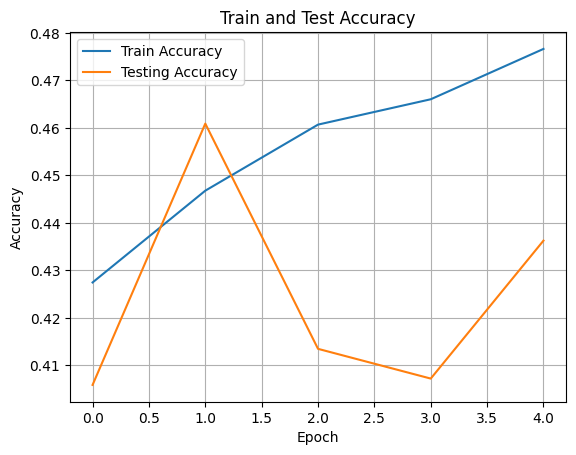

In [16]:
pp.plot(history.history['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history.history:
    pp.plot(history.history['val_accuracy'], label='Testing Accuracy')

pp.xlabel('Epoch')
pp.ylabel('Accuracy')
pp.title('Train and Test Accuracy')
pp.legend()
pp.grid(True)
pp.show()

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,597,809 (21.35 MB)

 Trainable params: 1,865,893 (7.12 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 3,731,788 (14.24 MB)

In [18]:
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred_classes,zero_division=0))

305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00       253
           2       0.47      0.63      0.54      3988
           3       0.45      0.50      0.47      3962
           4       0.00      0.00      0.00      1536

    accuracy                           0.46      9746
   macro avg       0.18      0.23      0.20      9746
weighted avg       0.38      0.46      0.41      9746



In [20]:
y_pred = model.predict(X_train)
y_pred_classes = y_pred.argmax(axis=1)
print(classification_report(y_train, y_pred_classes,zero_division=0))

1219/1219 ━━━━━━━━━━━━━━━━━━━━ 45s 37ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.00      0.00      0.00       937
           2       0.42      0.55      0.48     16278
           3       0.41      0.44      0.42     15805
           4       0.00      0.00      0.00      5933

    accuracy                           0.41     38980
   macro avg       0.16      0.20      0.18     38980
weighted avg       0.34      0.41      0.37     38980

